In [1]:
%cd /home/hotson/kaggle_work/csiro-biomass/

/home/hotson/kaggle_work/csiro-biomass


# Imports

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold
from IPython.display import display

In [3]:
train_df = pd.read_csv("train.csv")
train_df['sample_id'] = train_df['sample_id'].apply(lambda x: x.split("_")[0])
train_df = train_df.groupby(by = "sample_id").agg(list).reset_index()

info_cols = ["image_path", "Sampling_Date", "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"]
for col in info_cols: train_df[col] = train_df[col].apply(lambda x: x[0])


target_values = train_df.apply(
    lambda row: pd.Series(dict(zip(row["target_name"], row["target"]))), axis=1
)

train_df = pd.concat([train_df.drop(columns=["target_name", "target"]), target_values], axis=1)

train_df

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...,...,...,...,...,...,...
352,ID975115267,train/ID975115267.jpg,2015/7/8,WA,Clover,0.73,3.0000,40.0300,0.0000,0.8000,40.8300,40.8300
353,ID978026131,train/ID978026131.jpg,2015/9/4,Tas,Clover,0.83,3.1667,24.6445,4.1948,12.0601,40.8994,36.7046
354,ID980538882,train/ID980538882.jpg,2015/2/24,NSW,Phalaris,0.69,29.0000,0.0000,1.1457,91.6543,92.8000,91.6543
355,ID980878870,train/ID980878870.jpg,2015/7/8,WA,Clover,0.74,2.0000,32.3575,0.0000,2.0325,34.3900,34.3900


## Null check

In [4]:
train_df.isnull().sum()

sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
Dry_Clover_g     0
Dry_Dead_g       0
Dry_Green_g      0
Dry_Total_g      0
GDM_g            0
dtype: int64

## Validation

In [5]:
gdm_match = np.isclose(
    train_df["Dry_Green_g"] + train_df["Dry_Clover_g"],
    train_df["GDM_g"]
)

total_match_1 = np.isclose(
    train_df["Dry_Green_g"] + train_df["Dry_Clover_g"] + train_df["Dry_Dead_g"],
    train_df["Dry_Total_g"]
)

total_match_2 = np.isclose(
    train_df["GDM_g"] + train_df["Dry_Dead_g"],
    train_df["Dry_Total_g"]
)

# Create summary DataFrame
results_df = pd.DataFrame({
    "Validation": ["GDM_g = Green + Clover", 
                   "Total = Green + Clover + Dead", 
                   "Total = GDM + Dead"],
    "Matches": [gdm_match.sum(), total_match_1.sum(), total_match_2.sum()],
    "Mismatches": [len(train_df) - gdm_match.sum(),
                   len(train_df) - total_match_1.sum(),
                   len(train_df) - total_match_2.sum()],
    "Match %": [gdm_match.mean() * 100,
                total_match_1.mean() * 100,
                total_match_2.mean() * 100]
})

print(results_df)


                      Validation  Matches  Mismatches    Match %
0         GDM_g = Green + Clover      356           1  99.719888
1  Total = Green + Clover + Dead      356           1  99.719888
2             Total = GDM + Dead      356           1  99.719888


## Correlation plot

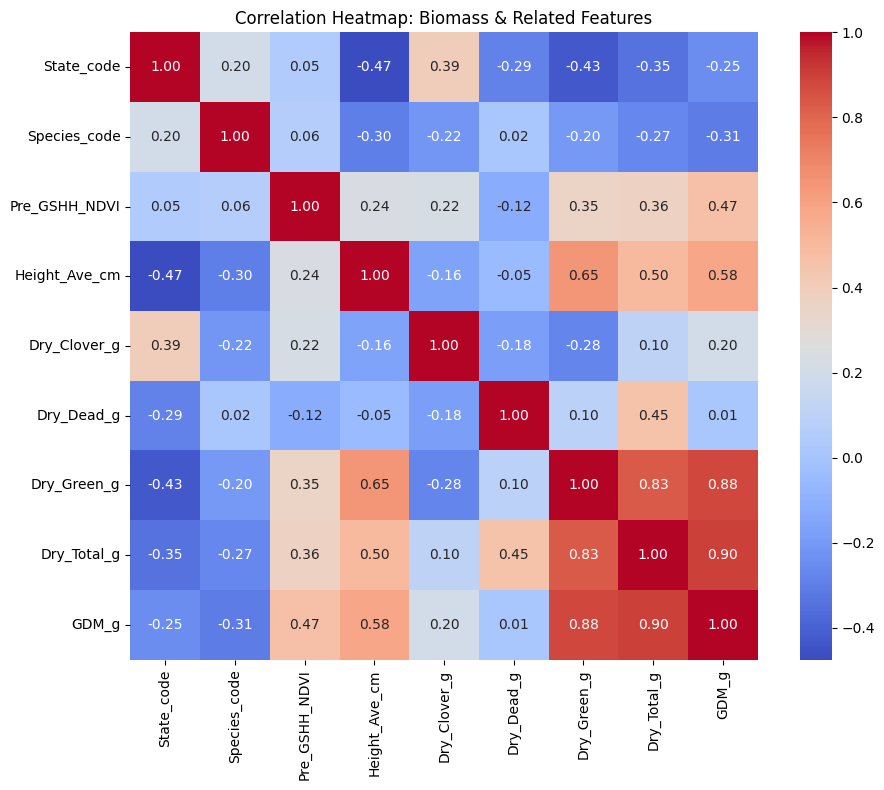

In [6]:
# Encode categorical variables
train_df["State_code"] = train_df["State"].astype("category").cat.codes
train_df["Species_code"] = train_df["Species"].astype("category").cat.codes

# Correlation plot
corr_df = train_df[[
    "State_code", "Species_code", "Pre_GSHH_NDVI", "Height_Ave_cm",
    "Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"
]]

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap: Biomass & Related Features")
plt.tight_layout()
plt.show()

## Distribution

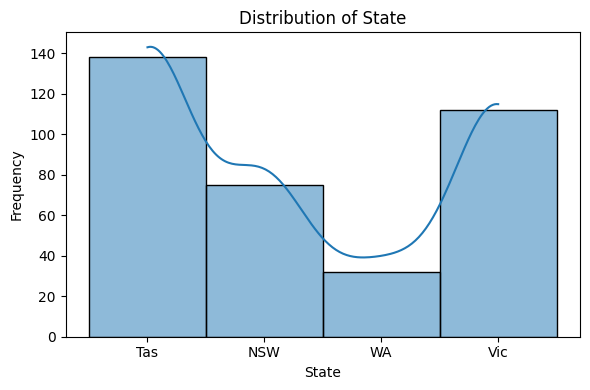

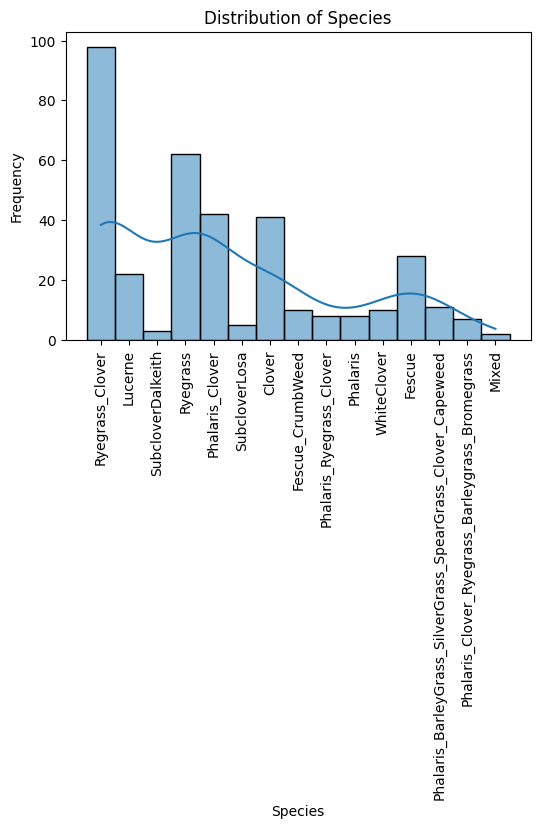

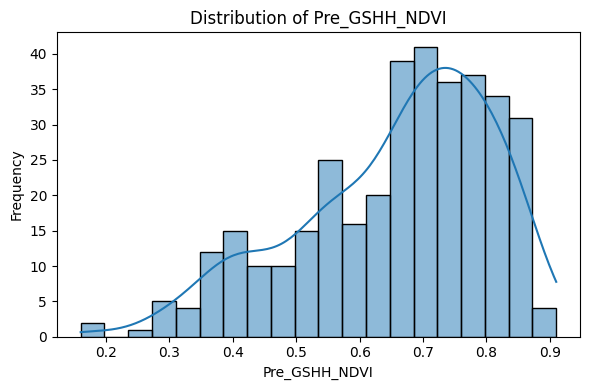

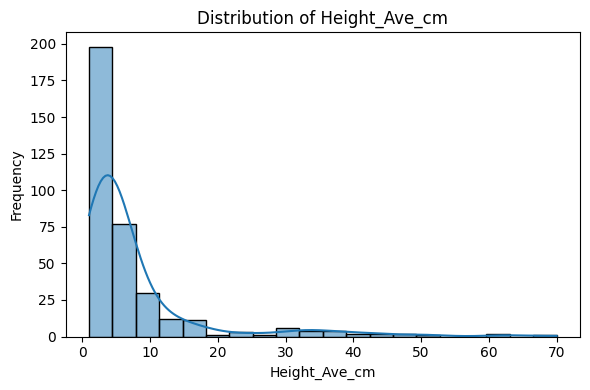

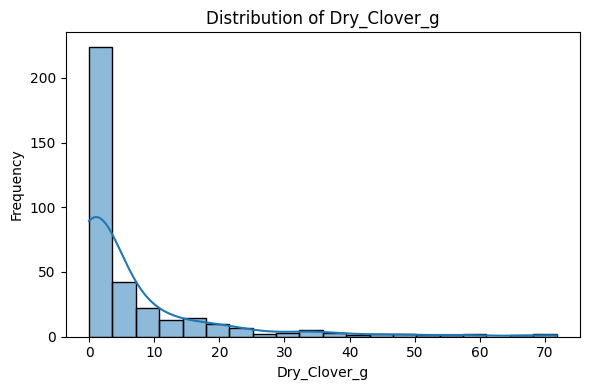

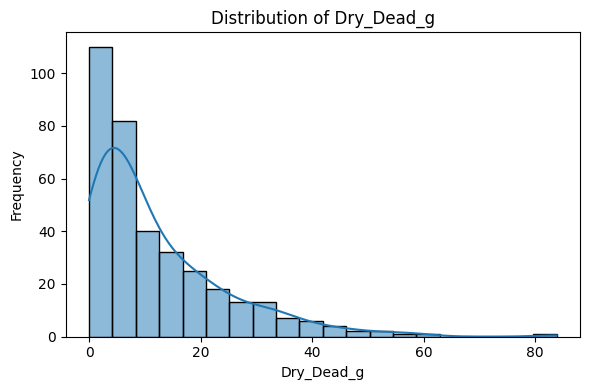

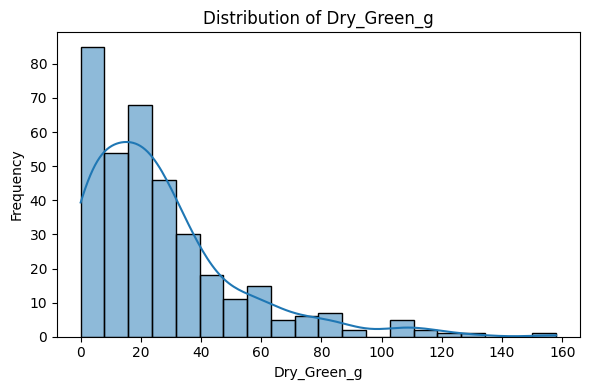

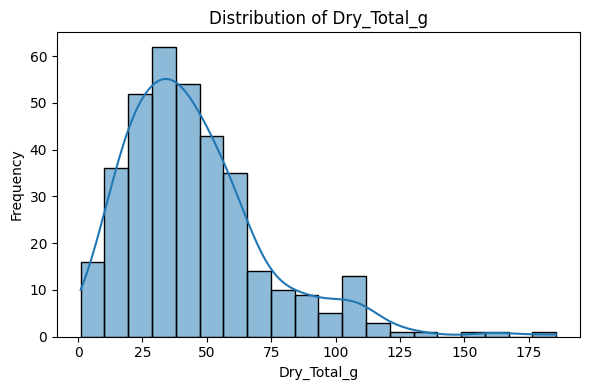

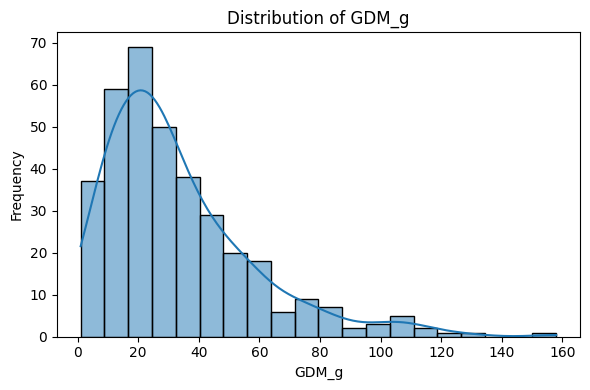

In [7]:
# Columns to plot
columns_to_plot = [
    "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm",
    "Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"
]

# Create separate distribution plots
for col in columns_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if col == "Species": plt.xticks(rotation = 90)
    if col != "Species":plt.tight_layout()
    plt.show()

In [8]:
train_df.to_csv("dataset/train_df.csv", index = False)
train_df

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,State_code,Species_code
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750,1,11
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000,0,3
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500,3,12
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376,1,10
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,ID975115267,train/ID975115267.jpg,2015/7/8,WA,Clover,0.73,3.0000,40.0300,0.0000,0.8000,40.8300,40.8300,3,0
353,ID978026131,train/ID978026131.jpg,2015/9/4,Tas,Clover,0.83,3.1667,24.6445,4.1948,12.0601,40.8994,36.7046,1,0
354,ID980538882,train/ID980538882.jpg,2015/2/24,NSW,Phalaris,0.69,29.0000,0.0000,1.1457,91.6543,92.8000,91.6543,0,5
355,ID980878870,train/ID980878870.jpg,2015/7/8,WA,Clover,0.74,2.0000,32.3575,0.0000,2.0325,34.3900,34.3900,3,0


# Selecting best splits

### "Dry_Green_g", "Dry_Dead_g", "Dry_Total_g" based strata

fold
0    72
1    72
2    71
3    71
4    71
Name: count, dtype: int64

==================== STRATIFIED FOLD 0 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,27.096955,684.148700
Dry_Dead_g,12.010876,152.298297
Dry_Clover_g,6.705362,148.963718
GDM_g,33.802315,657.630332
Dry_Total_g,45.812107,809.878027



[VAL] mean & variance


,mean,var
Dry_Green_g,24.755469,494.167352
Dry_Dead_g,12.177832,161.999463
Dry_Clover_g,6.429332,140.352269
GDM_g,31.184804,481.665723
Dry_Total_g,43.362637,682.185605


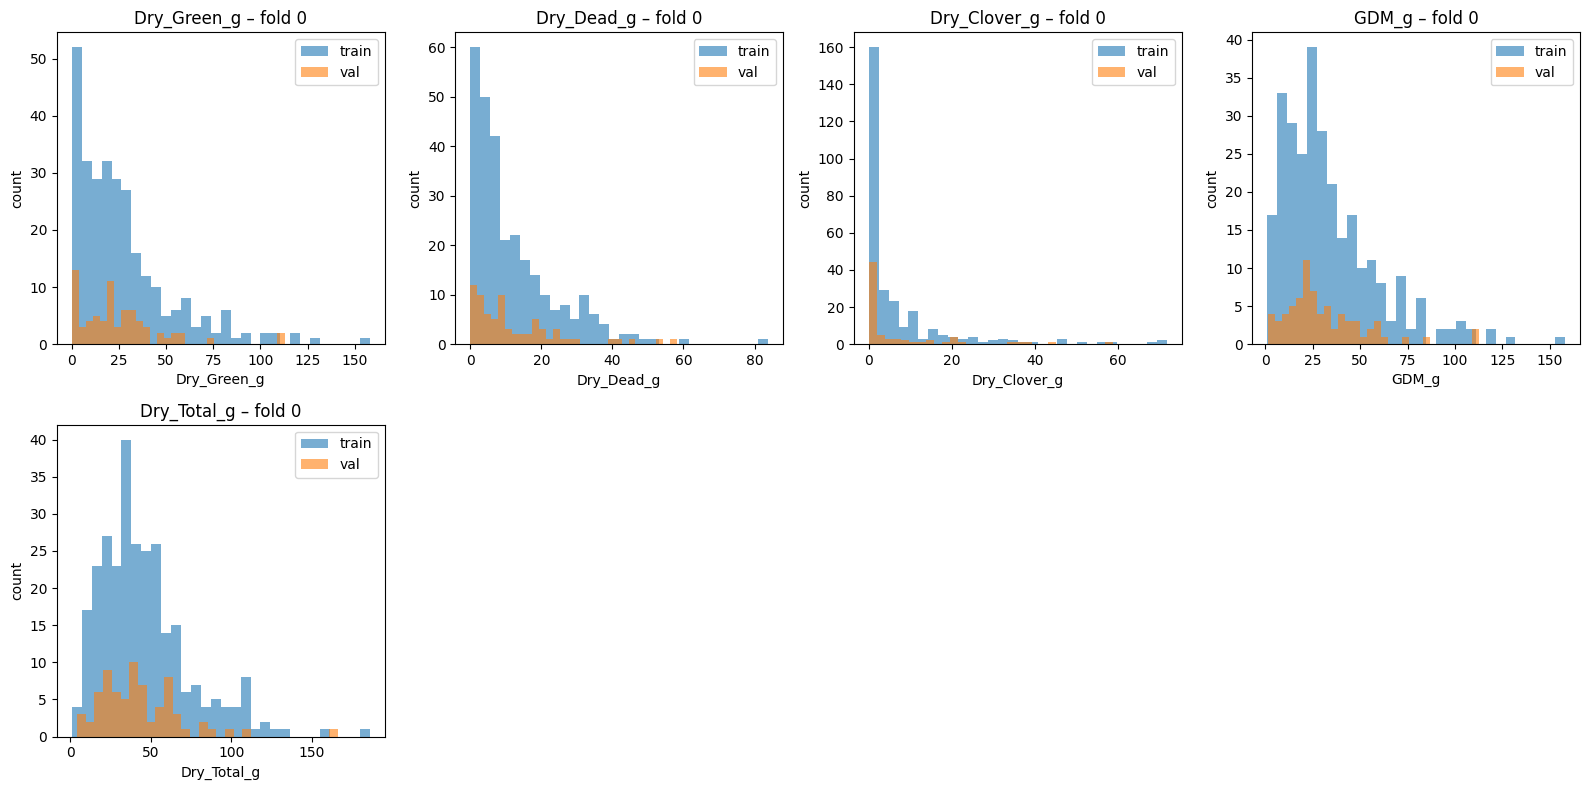


==================== STRATIFIED FOLD 1 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,26.523027,652.186186
Dry_Dead_g,11.828580,147.863679
Dry_Clover_g,6.630585,138.872194
GDM_g,33.153611,628.147054
Dry_Total_g,44.981107,796.229397



[VAL] mean & variance


,mean,var
Dry_Green_g,27.027265,626.250043
Dry_Dead_g,12.899421,178.832175
Dry_Clover_g,6.725324,180.772783
GDM_g,33.752592,604.854994
Dry_Total_g,46.652015,739.377178


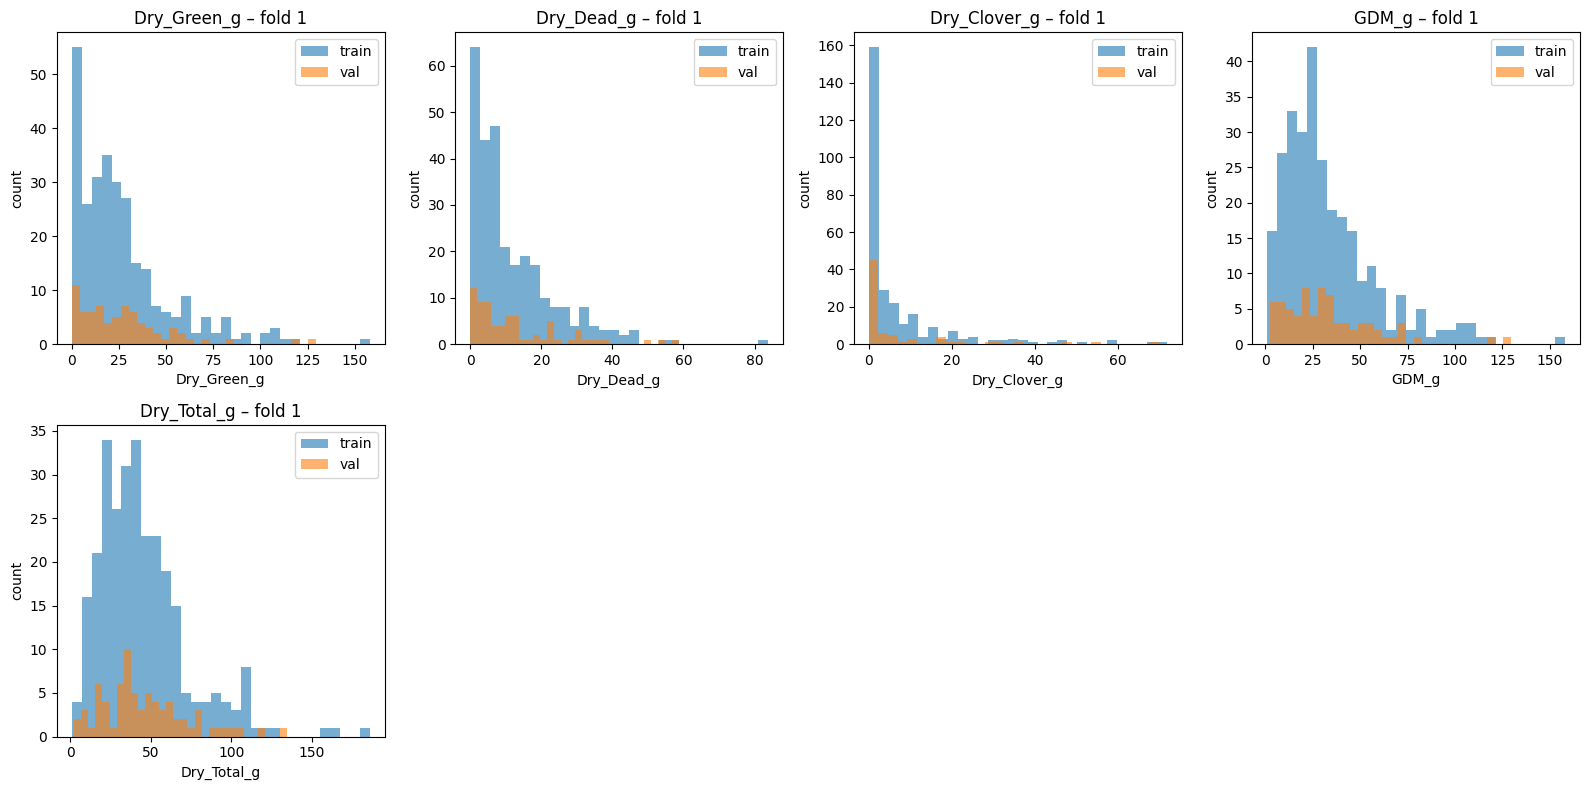


==================== STRATIFIED FOLD 2 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,26.074697,566.518981
Dry_Dead_g,12.295878,163.320234
Dry_Clover_g,6.421211,135.797248
GDM_g,32.495909,538.094342
Dry_Total_g,44.790707,724.491730



[VAL] mean & variance


,mean,var
Dry_Green_g,28.840318,968.661175
Dry_Dead_g,11.032146,115.988229
Dry_Clover_g,7.570052,192.825703
GDM_g,36.410363,959.009142
Dry_Total_g,47.442510,1027.218323


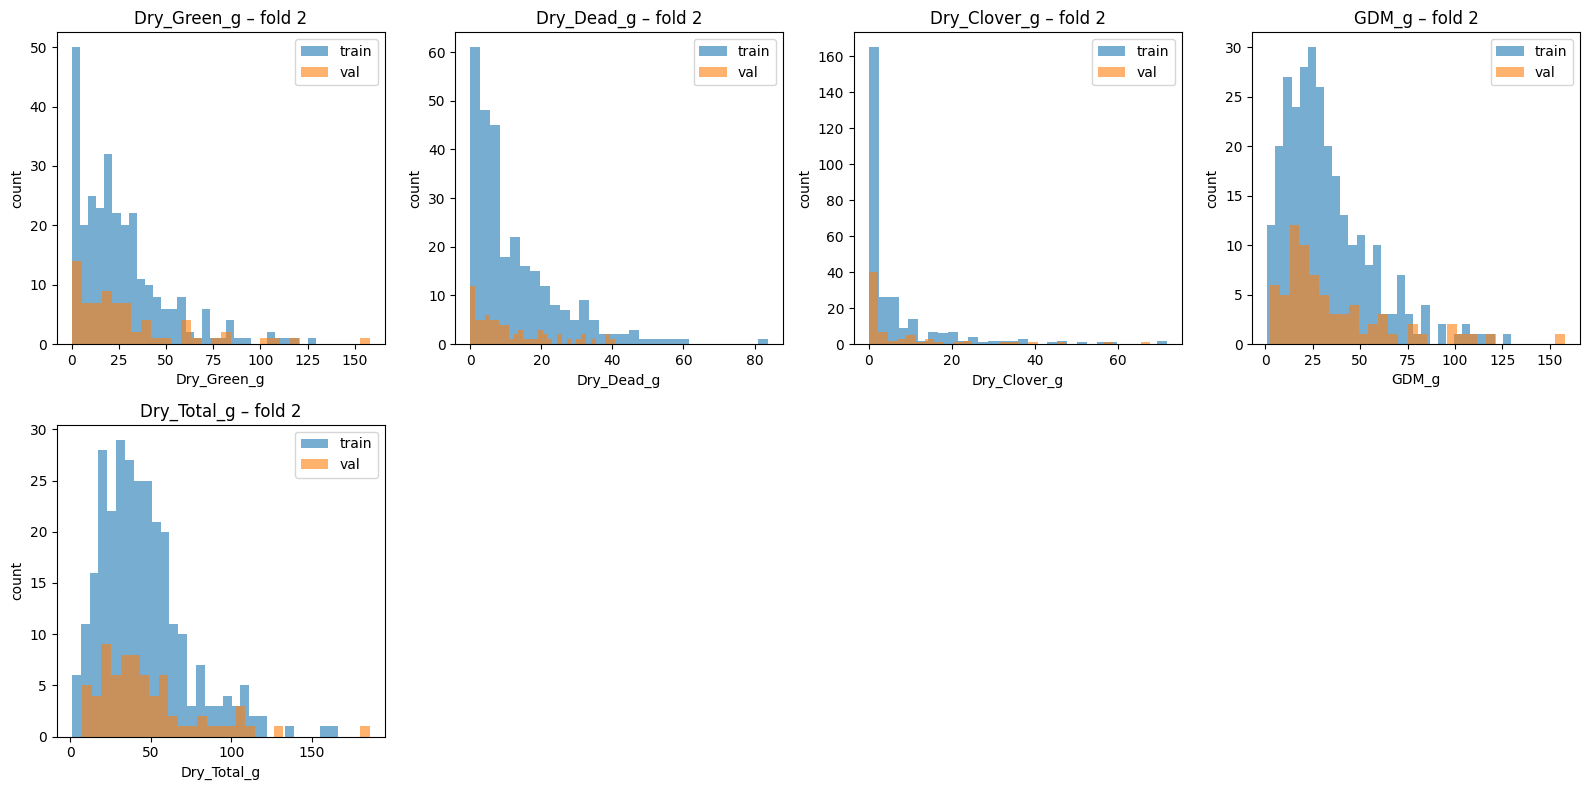


==================== STRATIFIED FOLD 3 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,26.673459,668.867201
Dry_Dead_g,11.748490,144.106648
Dry_Clover_g,7.005160,164.443766
GDM_g,33.678619,653.421058
Dry_Total_g,45.427109,773.637267



[VAL] mean & variance


,mean,var
Dry_Green_g,26.428404,558.123950
Dry_Dead_g,13.237118,193.711998
Dry_Clover_g,5.217807,74.670059
GDM_g,31.646206,498.559085
Dry_Total_g,44.878977,832.595651


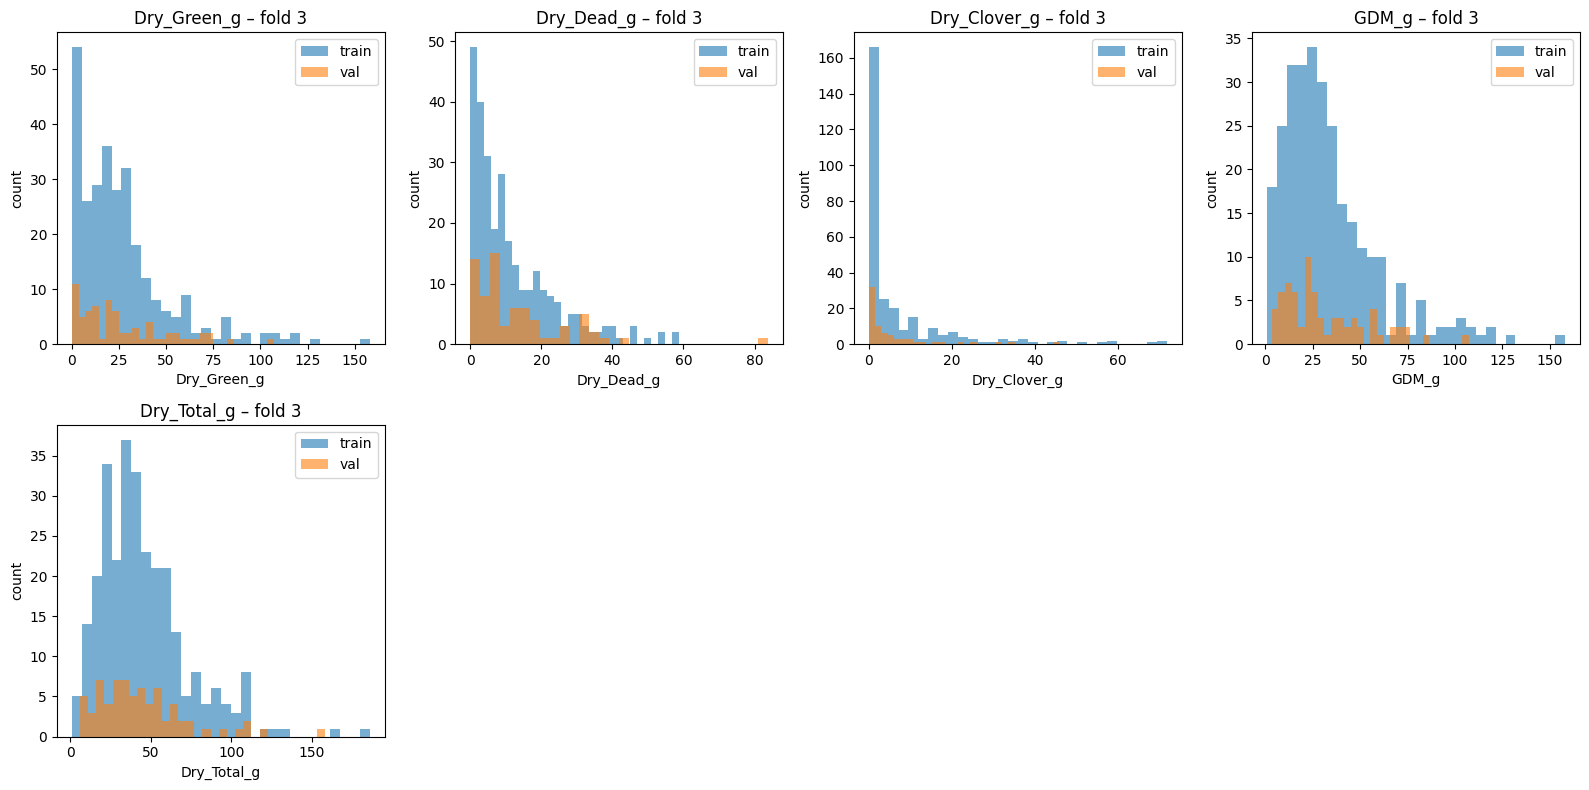


==================== STRATIFIED FOLD 4 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,26.756770,656.260054
Dry_Dead_g,12.338042,161.687977
Dry_Clover_g,6.486270,146.408998
GDM_g,33.243038,632.946548
Dry_Total_g,45.580002,813.459187



[VAL] mean & variance


,mean,var
Dry_Green_g,26.092813,609.143632
Dry_Dead_g,10.862303,122.161917
Dry_Clover_g,7.307985,150.144519
GDM_g,33.400800,585.255834
Dry_Total_g,44.263097,669.298501


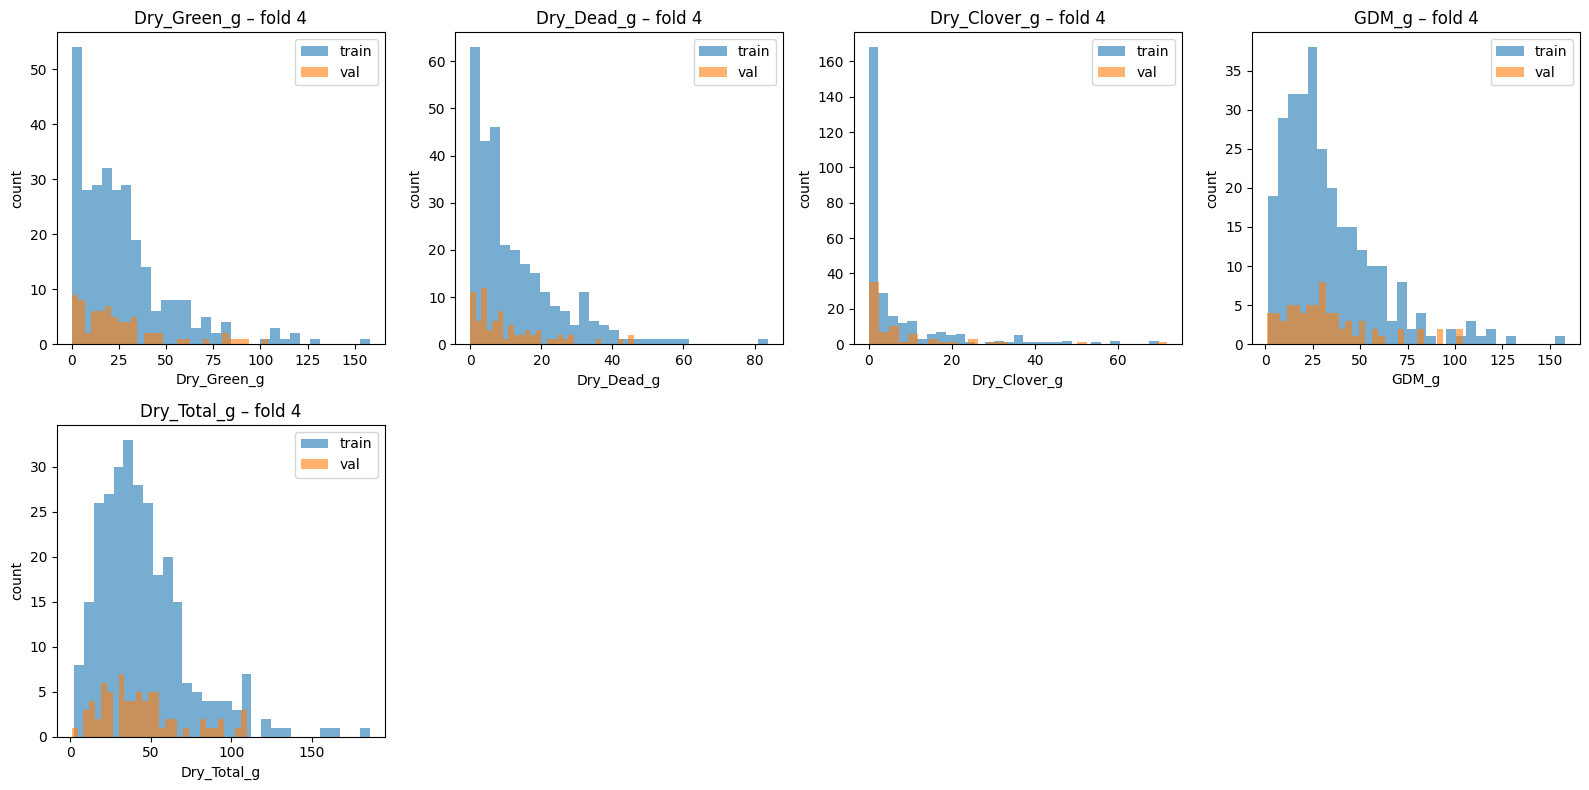

In [19]:
import numpy as np
import pandas as pd

def make_multitarget_strata(df: pd.DataFrame,
                            cols=None,
                            n_bins: int = 4,
                            n_splits: int = 5) -> np.ndarray:
    """
    Create a stratification label for multi-target regression.

    - Quantile-bin each target column into `n_bins`.
    - Combine the bins into a single integer code.
    - Reassign rare codes to the most common one so every class has >= n_splits samples.
    """
    if cols is None:
        cols = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g"]

    n = len(df)
    strat = np.zeros(n, dtype=int)

    for i, col in enumerate(cols):
        # qcut -> quantile bins 0..n_bins-1
        # duplicates="drop" handles constant columns
        bins = pd.qcut(df[col],
                       q=n_bins,
                       labels=False,
                       duplicates="drop")
        bins = bins.fillna(0).astype(int)  # in case of NaNs
        strat += bins.to_numpy() * (n_bins ** i)

    # Ensure each stratum has at least n_splits samples
    vc = pd.Series(strat).value_counts()

    # strata with < n_splits samples
    rare_labels = vc[vc < n_splits].index

    if len(rare_labels) > 0:
        # send all rare ones into the most frequent stratum
        majority_label = vc.idxmax()
        mask = np.isin(strat, rare_labels)
        strat[mask] = majority_label

    return strat


# choose which targets you want to inspect (5 or 7; your call)
target_cols = [
    "Dry_Green_g",
    "Dry_Dead_g",
    "Dry_Clover_g",
    "GDM_g",
    "Dry_Total_g",
    # "Pre_GSHH_NDVI",
    # "Height_Ave_cm",
]

# start from original train_df
tmp_df = train_df.copy()

# ensure numeric
for c in target_cols:
    tmp_df[c] = pd.to_numeric(tmp_df[c], errors="coerce")

# --- make strata exactly like your Runner did ---
tmp_df["strata"] = make_multitarget_strata(
    tmp_df,
    cols=["Dry_Green_g", "Dry_Dead_g", "Dry_Total_g"],  # same as before
    n_bins=4,
    n_splits=5,
)

# --- StratifiedKFold on strata ---
n_splits = 5
skf = StratifiedKFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42,
)

tmp_df["fold"] = -1

for fold, (_, va_idx) in enumerate(skf.split(tmp_df, tmp_df["strata"])):
    tmp_df.loc[tmp_df.index[va_idx], "fold"] = fold

print(tmp_df["fold"].value_counts().sort_index())

for fold in range(n_splits):
    print(f"\n==================== STRATIFIED FOLD {fold} ====================")
    
    train = tmp_df[tmp_df["fold"] != fold]
    val   = tmp_df[tmp_df["fold"] == fold]
    
    # ---- mean & variance tables ----
    print("\n[TRAIN] mean & variance")
    train_stats = train[target_cols].agg(["mean", "var"]).T
    display(train_stats)
    
    print("\n[VAL] mean & variance")
    val_stats = val[target_cols].agg(["mean", "var"]).T
    display(val_stats)
    
    # ---- 2 x 4 grid of histograms ----
    n_rows, n_cols = 2, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, col in enumerate(target_cols):
        ax = axes[i]
        ax.hist(
            train[col].dropna(),
            bins=30,
            alpha=0.6,
            label="train",
        )
        ax.hist(
            val[col].dropna(),
            bins=30,
            alpha=0.6,
            label="val",
        )
        ax.set_title(f"{col} – fold {fold}")
        ax.set_xlabel(col)
        ax.set_ylabel("count")
        ax.legend()
    
    # hide unused cells if target_cols < 8
    for j in range(len(target_cols), len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

### Sampling Date and State

fold
0    74
1    66
2    75
3    67
4    75
Name: count, dtype: int64

==================== FOLD 0 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,27.843567,607.837731
Dry_Dead_g,10.098909,123.017005
Dry_Clover_g,4.844300,87.788691
GDM_g,32.687865,608.434358
Dry_Total_g,42.785683,672.296624
Pre_GSHH_NDVI,0.676572,0.019438
Height_Ave_cm,8.232156,127.274982



[VAL] mean & variance


,mean,var
Dry_Green_g,21.963465,770.695378
Dry_Dead_g,19.485300,204.071108
Dry_Clover_g,13.554096,316.008434
GDM_g,35.517566,675.491640
Dry_Total_g,55.002866,1101.945667
Pre_GSHH_NDVI,0.584189,0.030934
Height_Ave_cm,5.163064,16.656777


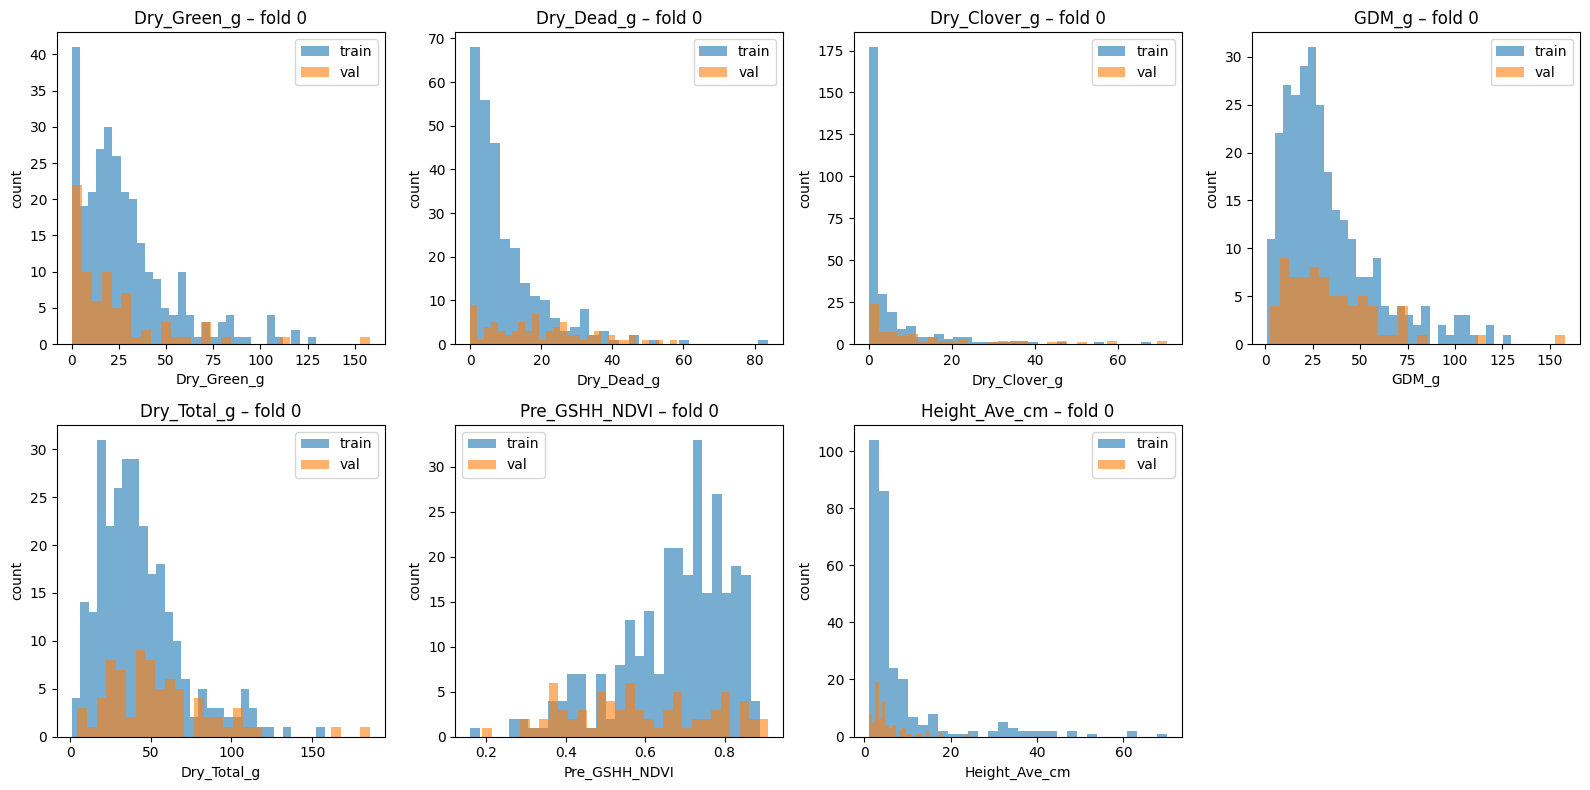


==================== FOLD 1 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,27.674826,722.694566
Dry_Dead_g,11.954264,131.954548
Dry_Clover_g,7.307656,169.114436
GDM_g,34.982481,698.670895
Dry_Total_g,46.935683,816.653251
Pre_GSHH_NDVI,0.651753,0.024906
Height_Ave_cm,7.954525,113.694208



[VAL] mean & variance


,mean,var
Dry_Green_g,21.994721,282.801438
Dry_Dead_g,12.442615,253.486634
Dry_Clover_g,3.748671,39.238008
GDM_g,25.743391,217.727138
Dry_Total_g,38.186012,582.112914
Pre_GSHH_NDVI,0.682424,0.014877
Height_Ave_cm,6.015153,69.021120


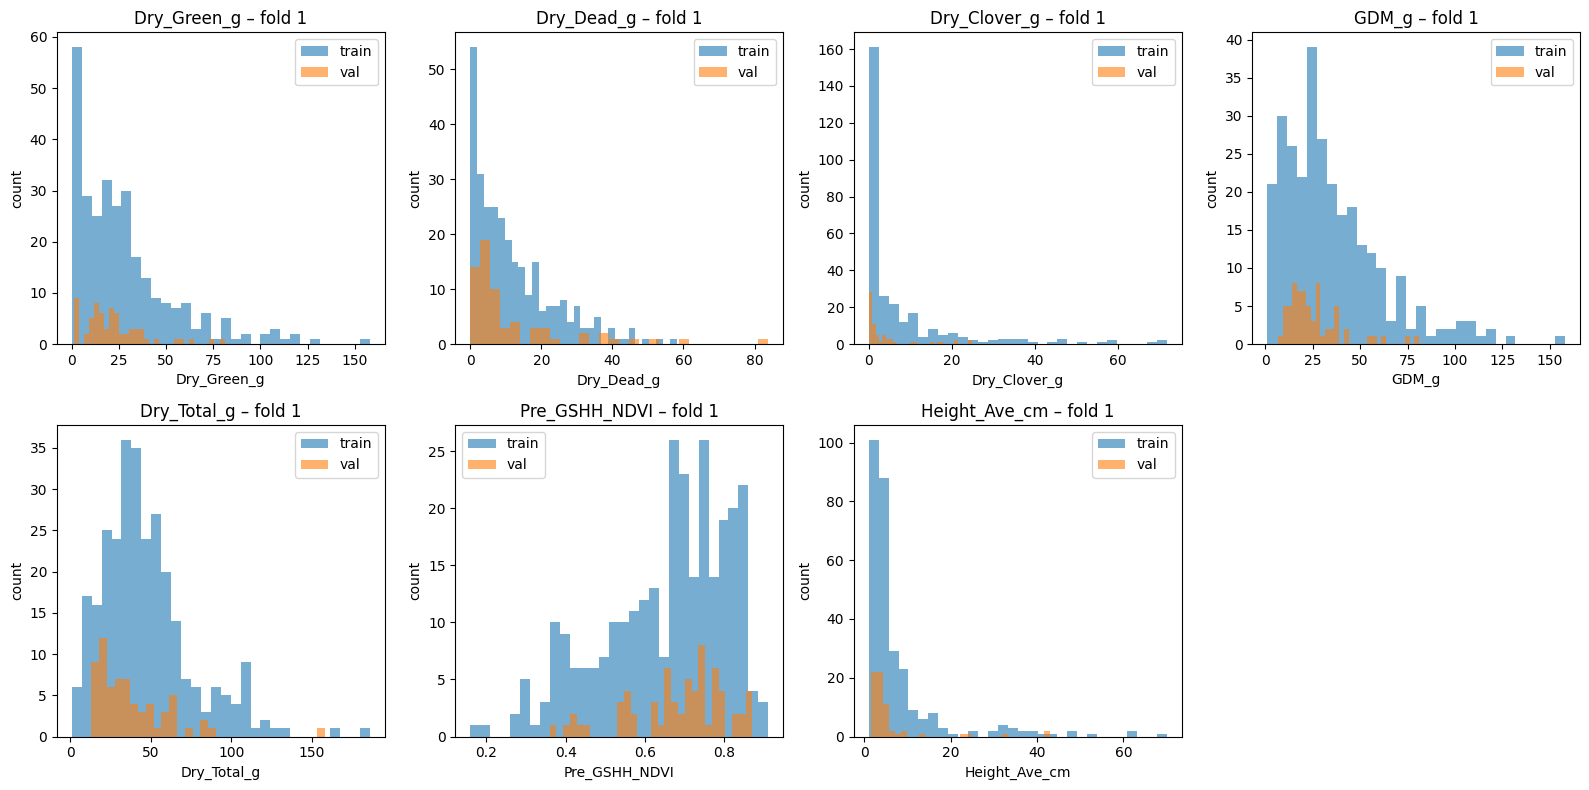


==================== FOLD 2 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,24.714210,532.981032
Dry_Dead_g,12.511421,168.543446
Dry_Clover_g,7.679935,163.488049
GDM_g,32.394143,542.011635
Dry_Total_g,44.904470,737.269077
Pre_GSHH_NDVI,0.671738,0.021514
Height_Ave_cm,7.484989,115.482253



[VAL] mean & variance


,mean,var
Dry_Green_g,33.808251,1013.946309
Dry_Dead_g,10.289105,95.986299
Dry_Clover_g,2.775980,66.354144
GDM_g,36.584231,919.103909
Dry_Total_g,46.873335,964.637043
Pre_GSHH_NDVI,0.603600,0.025945
Height_Ave_cm,8.013333,70.175495


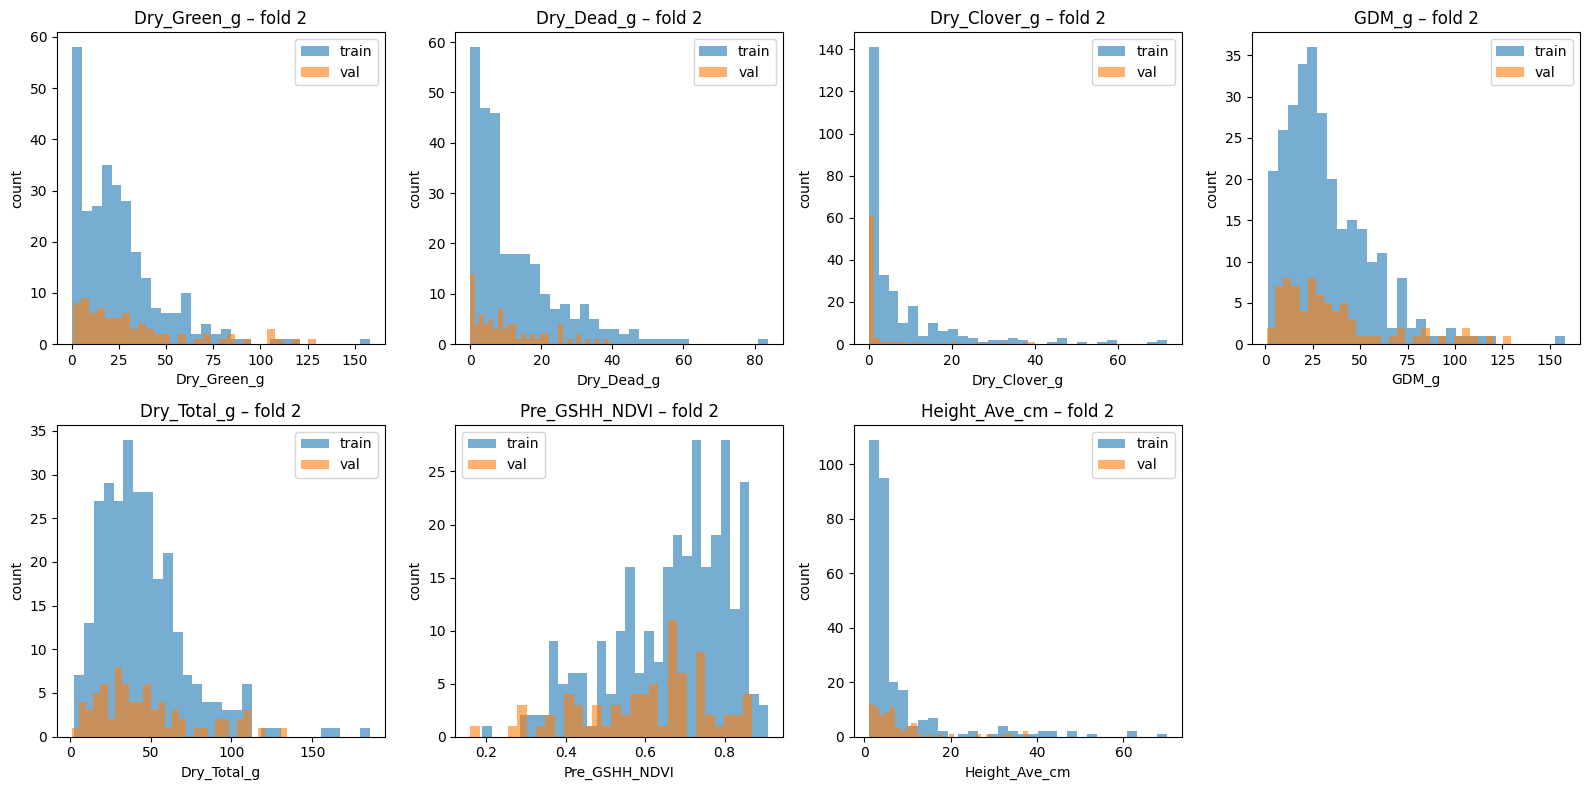


==================== FOLD 3 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,23.932784,651.802738
Dry_Dead_g,13.156337,175.244751
Dry_Clover_g,6.185496,149.002648
GDM_g,30.118281,581.653566
Dry_Total_g,43.273553,809.811891
Pre_GSHH_NDVI,0.634034,0.024554
Height_Ave_cm,6.676092,68.583348



[VAL] mean & variance


,mean,var
Dry_Green_g,38.276397,456.526310
Dry_Dead_g,7.232327,33.341441
Dry_Clover_g,8.658899,134.550905
GDM_g,46.935285,573.772270
Dry_Total_g,54.167612,580.158961
Pre_GSHH_NDVI,0.758657,0.004533
Height_Ave_cm,11.577612,250.482976


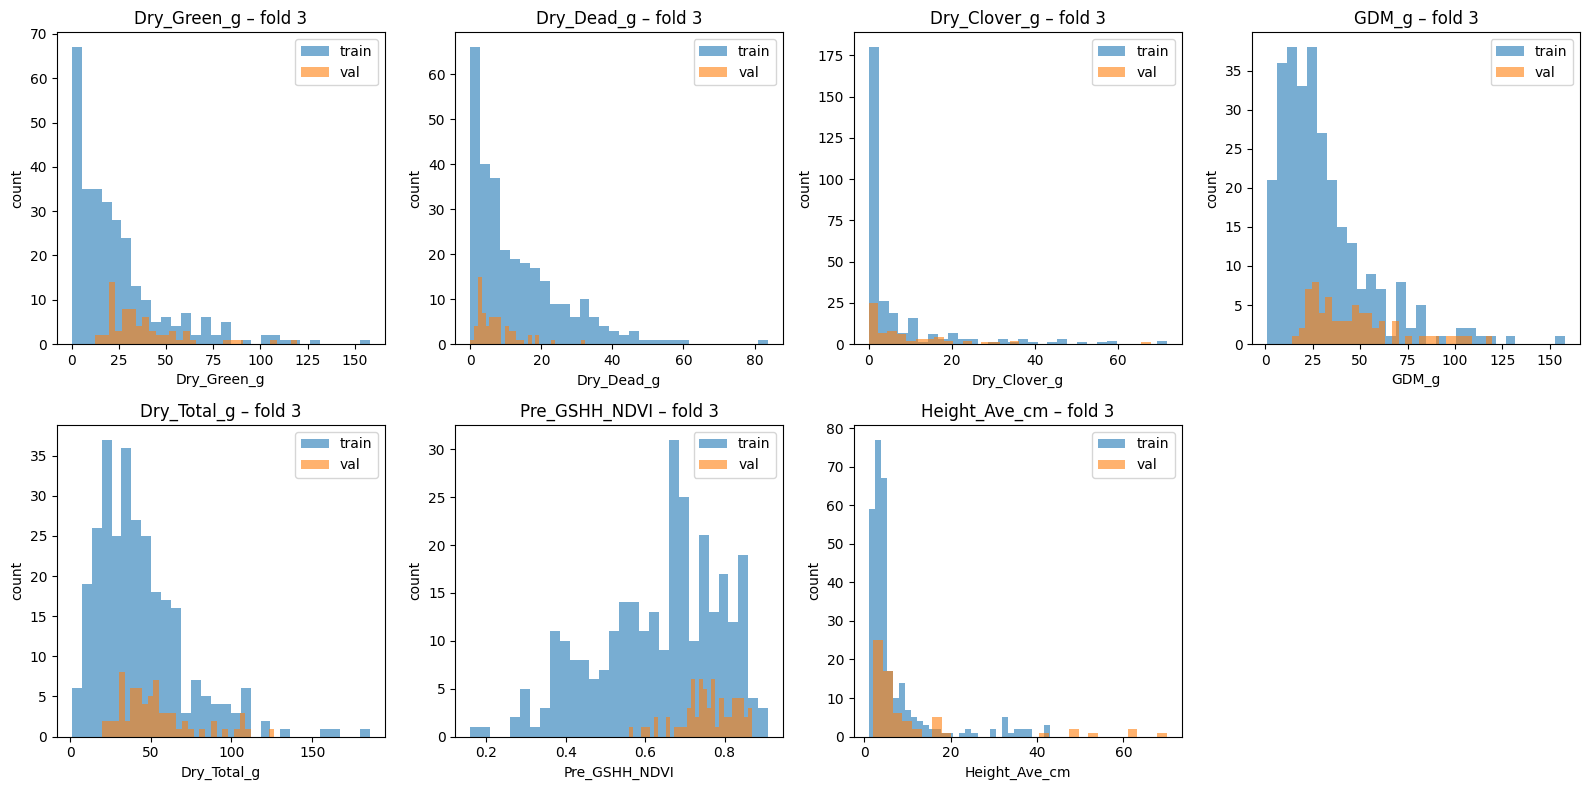


==================== FOLD 4 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,28.996757,691.131117
Dry_Dead_g,12.480048,165.530181
Dry_Clover_g,7.229646,159.408501
GDM_g,36.226401,655.975592
Dry_Total_g,48.706450,855.664877
Pre_GSHH_NDVI,0.653794,0.024138
Height_Ave_cm,7.644563,103.575456



[VAL] mean & variance


,mean,var
Dry_Green_g,17.705873,377.551002
Dry_Dead_g,10.407065,107.942081
Dry_Clover_g,4.469067,94.997480
GDM_g,22.174941,342.333307
Dry_Total_g,32.577887,309.898364
Pre_GSHH_NDVI,0.671067,0.019461
Height_Ave_cm,7.413333,115.569820


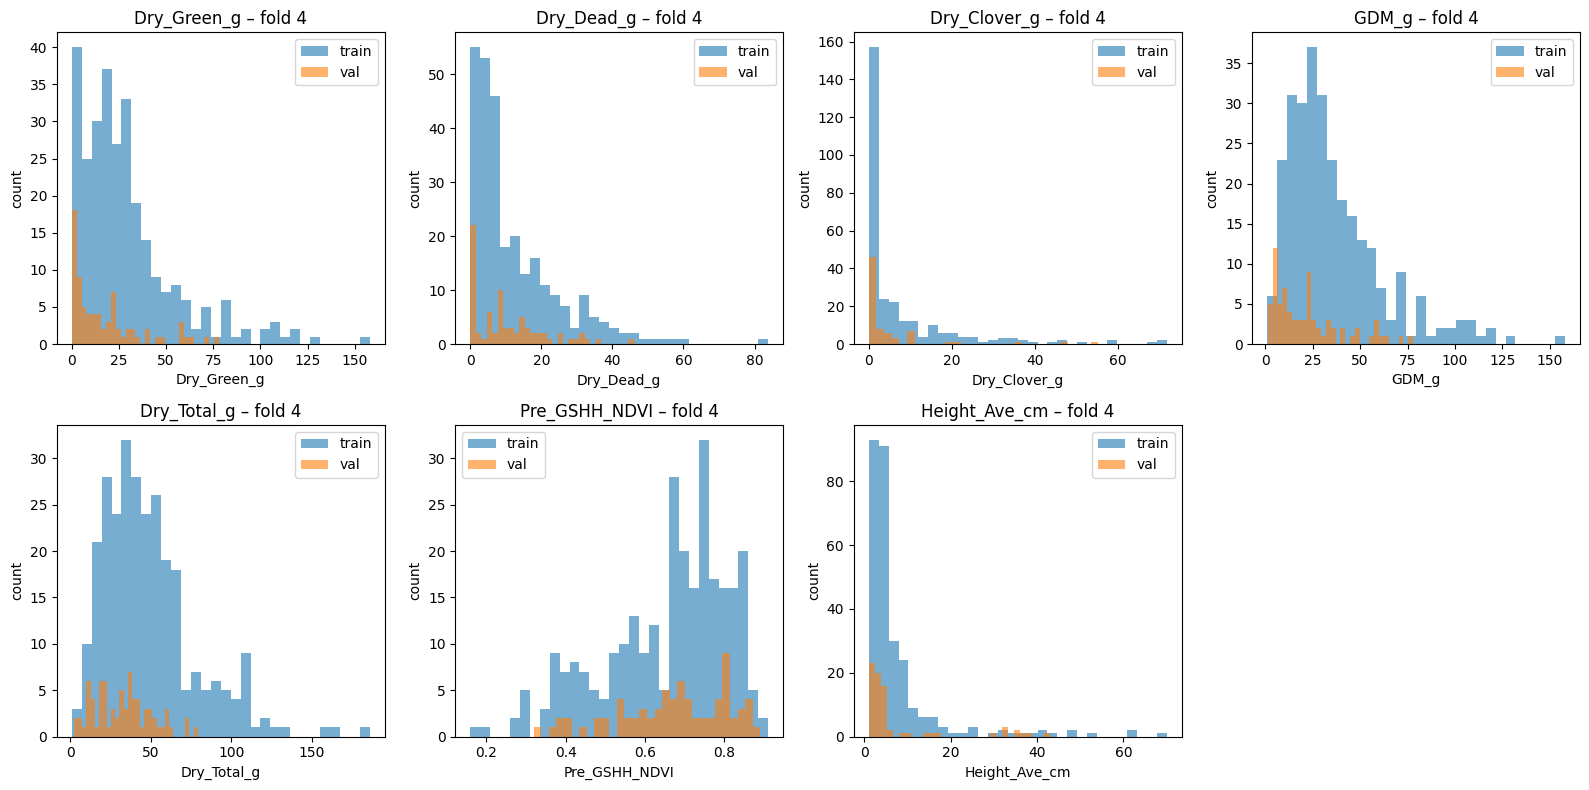

In [17]:
target_cols = [
    "Dry_Green_g",
    "Dry_Dead_g",
    "Dry_Clover_g",
    "GDM_g",
    "Dry_Total_g",
    "Pre_GSHH_NDVI",
    "Height_Ave_cm",
]

tmp_df = train_df.copy()

# Extract month from Sampling_Date (assumes format like "2015/10/13")
tmp_df["month"] = tmp_df["Sampling_Date"].str.split("/").str[1].astype(int)
tmp_df["env_group"] = tmp_df["State"] + "_" + tmp_df["month"].astype(str)

# GroupKFold split on env_group
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

tmp_df["fold"] = -1
groups = tmp_df["env_group"].values

for fold, (tr_idx, va_idx) in enumerate(gkf.split(tmp_df, groups=groups)):
    tmp_df.loc[tmp_df.index[va_idx], "fold"] = fold

print(tmp_df["fold"].value_counts().sort_index())

# For each fold: show mean & variance for train and val + grid plots
for fold in range(n_splits):
    print(f"\n==================== FOLD {fold} ====================")
    
    train = tmp_df[tmp_df["fold"] != fold]
    val   = tmp_df[tmp_df["fold"] == fold]
    
    print("\n[TRAIN] mean & variance")
    train_stats = train[target_cols].agg(["mean", "var"]).T
    display(train_stats)
    
    print("\n[VAL] mean & variance")
    val_stats = val[target_cols].agg(["mean", "var"]).T
    display(val_stats)
    
    # ---- GRID PLOTS: 2 x 4 (last one blank) ----
    n_rows, n_cols = 2, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = axes.ravel()  # flatten to 1D list of axes
    
    for i, col in enumerate(target_cols):
        ax = axes[i]
        ax.hist(
            train[col].dropna(),
            bins=30,
            alpha=0.6,
            label="train",
        )
        ax.hist(
            val[col].dropna(),
            bins=30,
            alpha=0.6,
            label="val",
        )
        ax.set_title(f"{col} – fold {fold}")
        ax.set_xlabel(col)
        ax.set_ylabel("count")
        ax.legend()
    
    # hide the unused subplot (8th cell, index 7) if you only have 7 targets
    if len(target_cols) < len(axes):
        axes[-1].axis("off")
    
    plt.tight_layout()
    plt.show()

### Sample_date, state and targets strata

fold
0    68
1    49
2    82
3    78
4    80
Name: count, dtype: int64

==================== FOLD 0 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,25.755353,625.434830
Dry_Dead_g,11.827529,144.619419
Dry_Clover_g,7.850391,170.978038
GDM_g,33.605743,612.581082
Dry_Total_g,45.432204,785.442367
Pre_GSHH_NDVI,0.657855,0.024661
Height_Ave_cm,5.646252,30.115320



[VAL] mean & variance


,mean,var
Dry_Green_g,30.319544,722.795071
Dry_Dead_g,12.966876,194.543727
Dry_Clover_g,1.546722,12.627254
GDM_g,31.866266,668.196668
Dry_Total_g,44.833140,784.451475
Pre_GSHH_NDVI,0.655588,0.016983
Height_Ave_cm,15.882353,346.553117


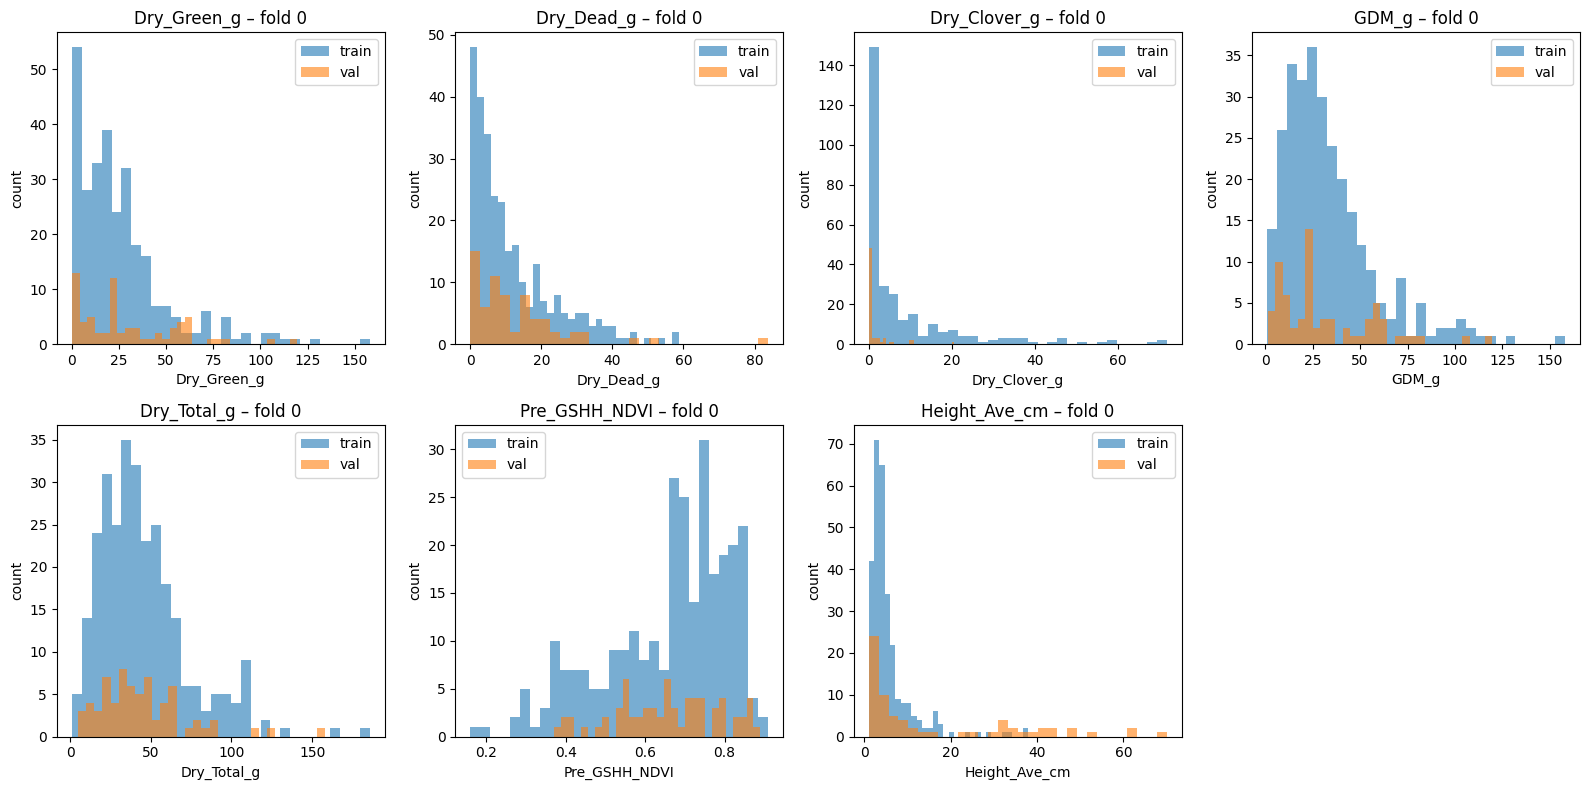


==================== FOLD 1 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,28.460871,709.669783
Dry_Dead_g,12.411653,158.886838
Dry_Clover_g,6.521437,155.791983
GDM_g,34.982306,680.240371
Dry_Total_g,47.392956,838.538818
Pre_GSHH_NDVI,0.670552,0.020994
Height_Ave_cm,8.282035,118.808335



[VAL] mean & variance


,mean,var
Dry_Green_g,15.083216,88.856358
Dry_Dead_g,9.737029,118.241783
Dry_Clover_g,7.455869,91.875733
GDM_g,22.539094,124.578859
Dry_Total_g,32.276122,243.614053
Pre_GSHH_NDVI,0.574898,0.029342
Height_Ave_cm,3.283676,2.702276


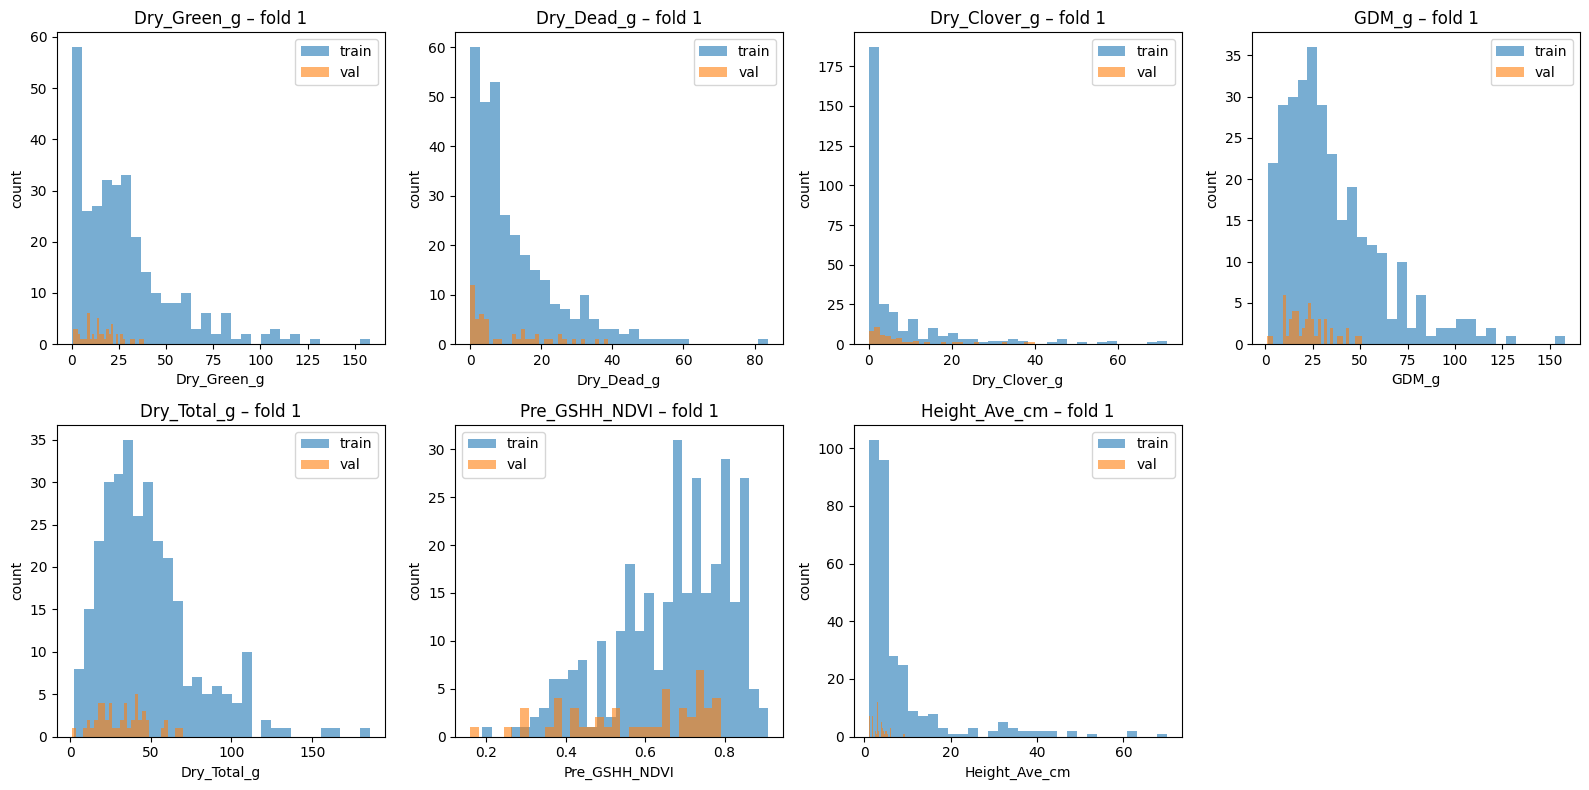


==================== FOLD 2 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,27.881514,626.130800
Dry_Dead_g,10.131581,114.767004
Dry_Clover_g,5.909889,129.796113
GDM_g,33.791403,624.169552
Dry_Total_g,43.921860,666.763572
Pre_GSHH_NDVI,0.663891,0.021863
Height_Ave_cm,8.409455,130.061886



[VAL] mean & variance


,mean,var
Dry_Green_g,22.409872,694.423563
Dry_Dead_g,18.459983,233.689319
Dry_Clover_g,9.130738,198.218316
GDM_g,31.540609,617.489294
Dry_Total_g,50.000596,1157.508216
Pre_GSHH_NDVI,0.635732,0.027158
Height_Ave_cm,4.867887,15.195276


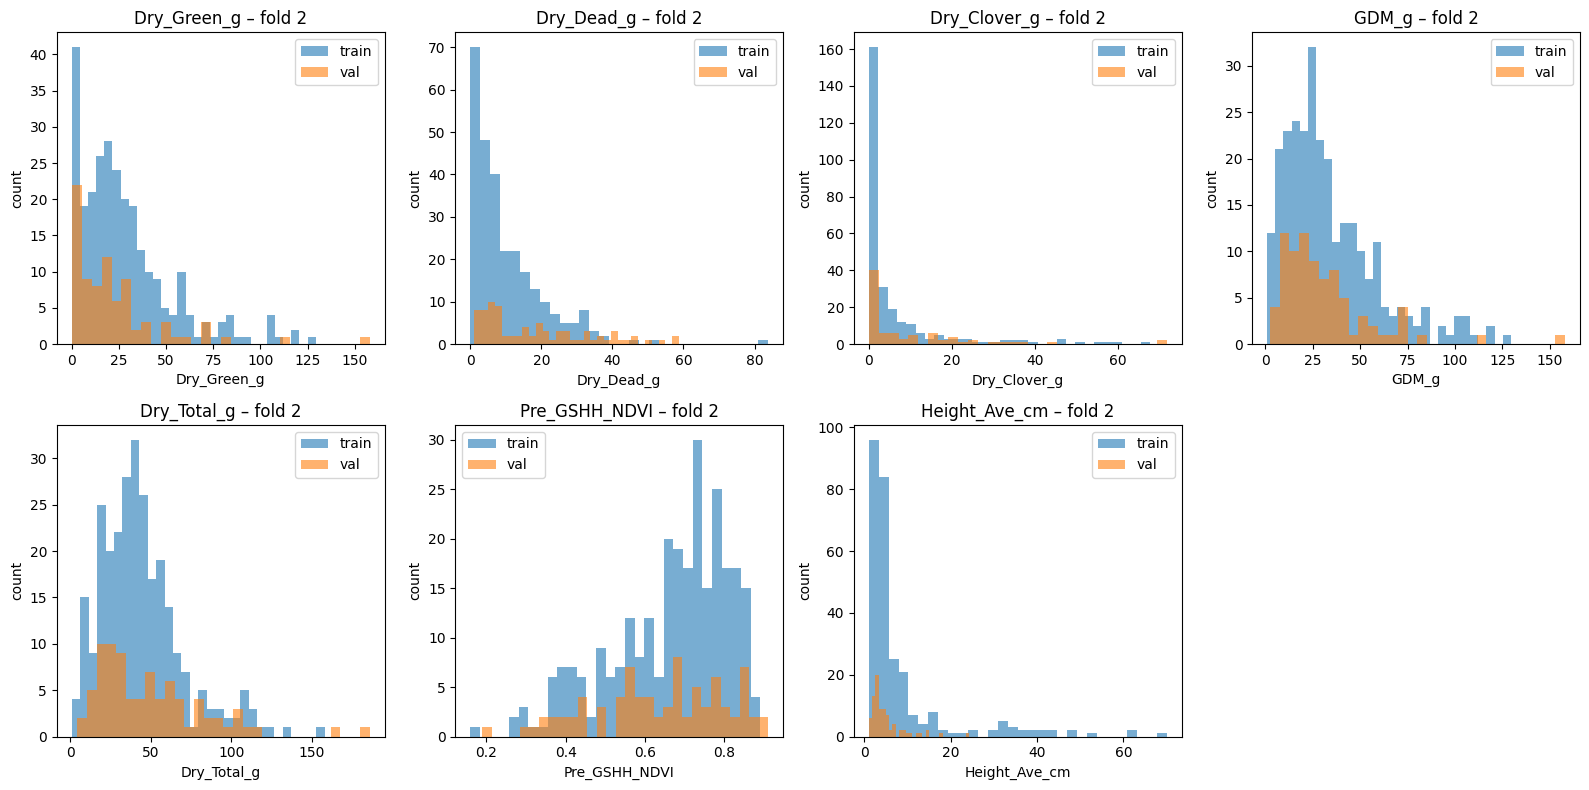


==================== FOLD 3 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,27.994708,744.872786
Dry_Dead_g,13.339799,168.449212
Dry_Clover_g,5.974460,121.052424
GDM_g,33.969168,726.147130
Dry_Total_g,47.307862,905.812701
Pre_GSHH_NDVI,0.648065,0.023491
Height_Ave_cm,8.480526,129.505241



[VAL] mean & variance


,mean,var
Dry_Green_g,21.724390,262.700412
Dry_Dead_g,7.411532,75.130786
Dry_Clover_g,9.064945,234.289573
GDM_g,30.789329,245.114532
Dry_Total_g,38.200859,284.594443
Pre_GSHH_NDVI,0.690897,0.020754
Height_Ave_cm,4.432051,8.551557


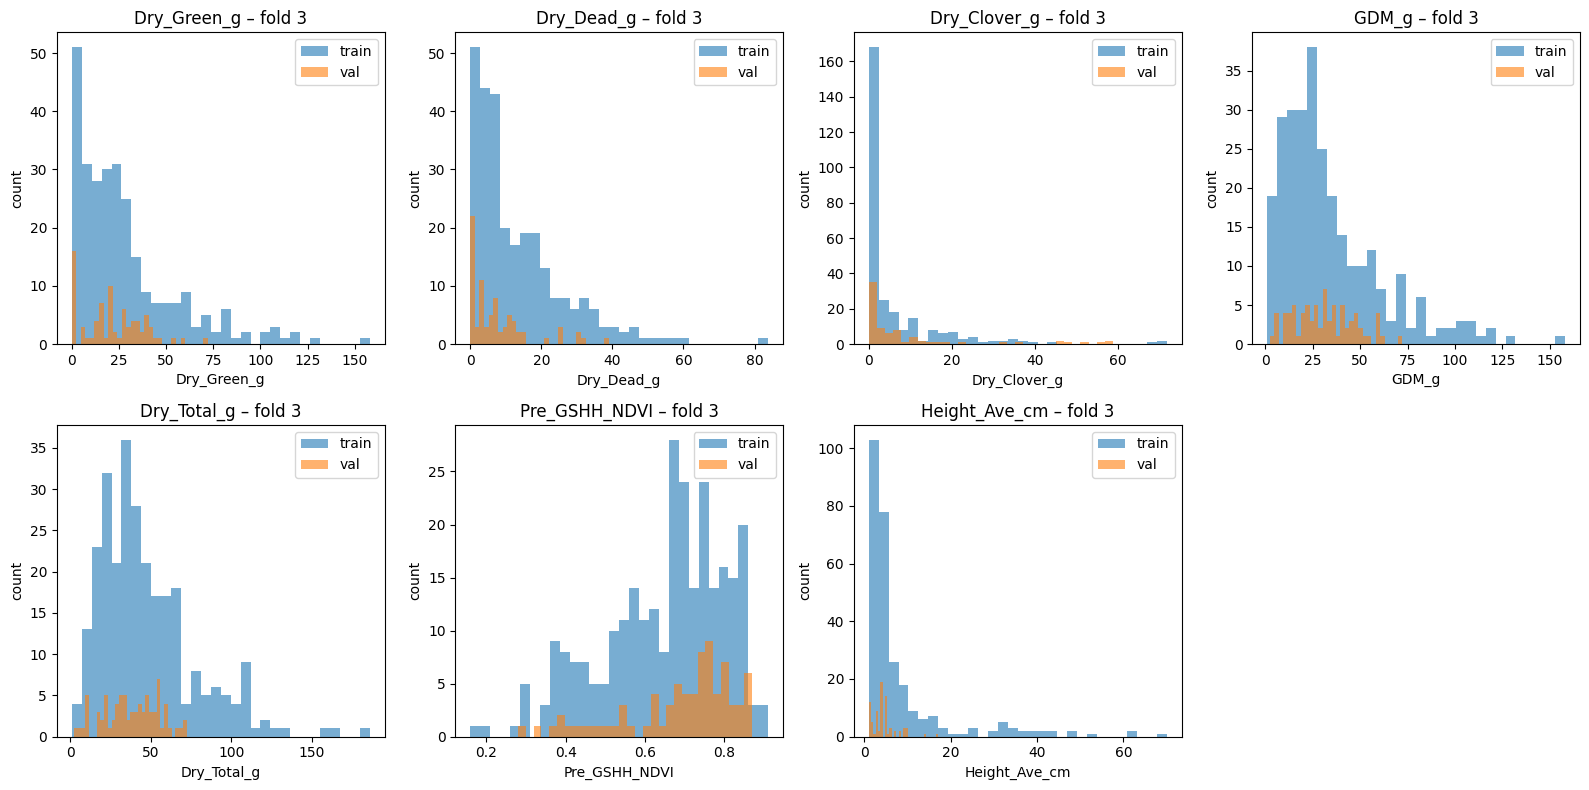


==================== FOLD 4 ====================

[TRAIN] mean & variance


,mean,var
Dry_Green_g,22.862522,492.873564
Dry_Dead_g,12.457329,176.611214
Dry_Clover_g,6.954155,152.495357
GDM_g,29.816676,445.064341
Dry_Total_g,42.274005,693.682637
Pre_GSHH_NDVI,0.645379,0.024507
Height_Ave_cm,7.168833,116.517998



[VAL] mean & variance


,mean,var
Dry_Green_g,39.651342,964.177385
Dry_Dead_g,10.615293,73.429950
Dry_Clover_g,5.595490,127.490930
GDM_g,45.246830,1060.030812
Dry_Total_g,55.858264,960.437592
Pre_GSHH_NDVI,0.699125,0.016421
Height_Ave_cm,9.075000,66.778861


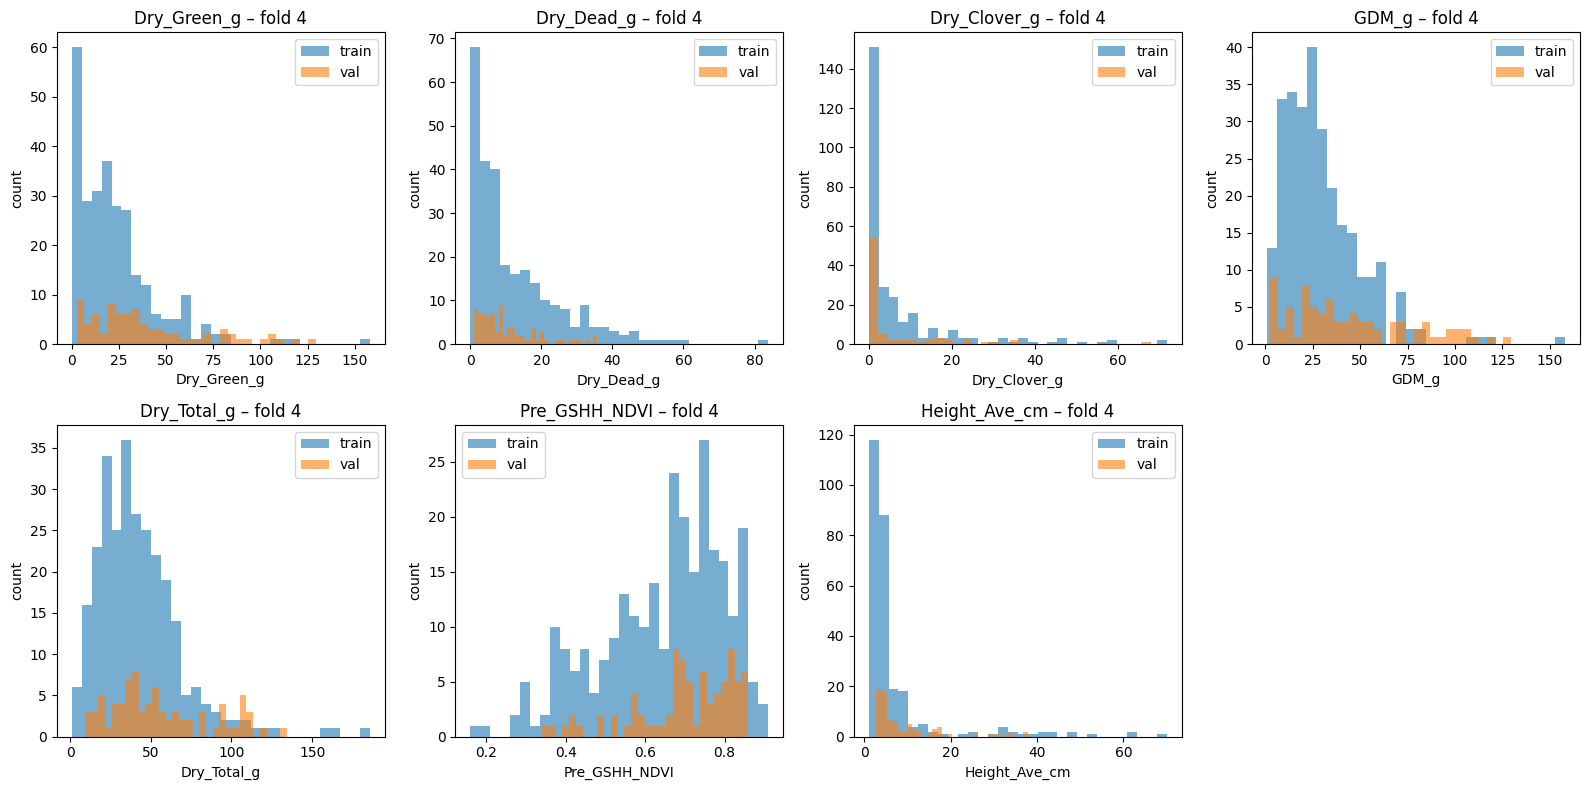

In [21]:
target_cols = [
    "Dry_Green_g",
    "Dry_Dead_g",
    "Dry_Clover_g",
    "GDM_g",
    "Dry_Total_g",
    "Pre_GSHH_NDVI",
    "Height_Ave_cm",
]

strata_cols = target_cols  # or only the 5 biomass columns if you prefer

tmp_df = train_df.copy()

# ensure numeric
for c in target_cols:
    tmp_df[c] = pd.to_numeric(tmp_df[c], errors="coerce")

# env_group = State + month(Sampling_Date)
tmp_df["month"] = tmp_df["Sampling_Date"].str.split("/").str[1].astype(int)
tmp_df["env_group"] = tmp_df["State"] + "_" + tmp_df["month"].astype(str)

# ---------- STRATA (multi-target bins) ----------
tmp_df["strata"] = make_multitarget_strata(
    tmp_df,
    cols=strata_cols,
    n_bins=4,
    n_splits=5,
)

# ---------- Stratified + Grouped KFold ----------
n_splits = 5
sgkf = StratifiedGroupKFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42,
)

tmp_df["fold"] = -1
X_dummy = np.zeros(len(tmp_df), dtype=np.int8)

for fold, (_, va_idx) in enumerate(
    sgkf.split(X_dummy, tmp_df["strata"].values, groups=tmp_df["env_group"].values)
):
    tmp_df.loc[tmp_df.index[va_idx], "fold"] = fold

print(tmp_df["fold"].value_counts().sort_index())

for fold in range(n_splits):
    print(f"\n==================== FOLD {fold} ====================")
    
    train = tmp_df[tmp_df["fold"] != fold]
    val   = tmp_df[tmp_df["fold"] == fold]
    
    # ---- mean & variance tables ----
    print("\n[TRAIN] mean & variance")
    train_stats = train[target_cols].agg(["mean", "var"]).T
    display(train_stats)
    
    print("\n[VAL] mean & variance")
    val_stats = val[target_cols].agg(["mean", "var"]).T
    display(val_stats)
    
    # ---- 2 x 4 grid of histograms ----
    n_rows, n_cols = 2, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, col in enumerate(target_cols):
        ax = axes[i]
        ax.hist(
            train[col].dropna(),
            bins=30,
            alpha=0.6,
            label="train",
        )
        ax.hist(
            val[col].dropna(),
            bins=30,
            alpha=0.6,
            label="val",
        )
        ax.set_title(f"{col} – fold {fold}")
        ax.set_xlabel(col)
        ax.set_ylabel("count")
        ax.legend()
    
    # hide unused subplot (8th cell) since we have 7 targets
    if len(target_cols) < len(axes):
        axes[-1].axis("off")
    
    plt.tight_layout()
    plt.show()
